# Network Parameters

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')

In [91]:
import matplotlib
matplotlib.use('Agg')
sns.set(rc={'text.usetex' : True})

In [95]:
matplotlib.rcParams['font.family'] = 'sans-serif'

In [2]:
from glob import glob
from os.path import join

In [146]:
import scipy.stats

In [174]:
import statsmodels.api as sm

#### Outline

 * Create a general tidy dataframe
 * Create a Grid figure with structural params per cutoff
 * Create a figure with linear regression in all tissues between degree and attribute assortativity

## Tidy DataFrame

In [192]:
DATA = "/Users/rdora/breast_cancer/data"
FIG = '/Users/rdora/Dropbox/inmegen/breast_cancer/article/figures/'
# Tables with network parameters are scattered
# around table_{TISSUE NAME}
tissues = ['healthy',
          'luma',
          'lumb',
          'her2',
          'basal']
params = ['cutoff',
          'dmin',
          'dmax',
         'dmean',
         'dstd',
         'ass',
         'ass_attr',
         'size']

In [193]:
dfs = []
for tissue in tissues:
    df = pd.read_csv(join(DATA, 'table_{}.csv'.format(tissue)))
    df = df[params]
    df = df.rename(columns={'cutoff': 'Layer',
                      'dmean': 'Mean Deg',
                      'dstd': 'Std Deg',
                      'dmin': 'Min Deg',
                      'dmax': 'Max Deg',
                      'ass': 'D.A',
                      'ass_attr': 'A.A',
                      'size': 'Size'})
    if tissue == 'healthy':
        tissue = 'Healthy'
    elif tissue == 'luma':
        tissue = 'Lum A'
    elif tissue == 'lumb':
        tissue = 'Lum B'
    elif tissue == 'her2':
        tissue = 'Her2'
    else:
        tissue = 'Basal'
    df['Tissue'] = tissue
    dfs.append(df)
df = pd.concat(dfs, axis=0)

In [194]:
df = df.replace('median', '0')
df = df.replace('low', '-1')
df['Layer'] = df['Layer'].astype(int)

In [195]:
df.head()

,Layer,Min Deg,Max Deg,Mean Deg,Std Deg,D.A,A.A,Size,Tissue
0,94,1,76,14.792599,10.830995,0.144910,0.010280,14161,Healthy
1,84,1,52,14.549243,8.244891,0.094900,0.005484,14398,Healthy
2,50,1,42,14.477711,5.709854,0.043044,0.002747,14469,Healthy
3,70,1,46,14.494707,6.767300,0.068603,0.003017,14453,Healthy
4,30,1,38,14.479928,5.193934,0.026176,0.002048,14473,Healthy


In [196]:
df_tidy = pd.melt(df, id_vars=["Tissue", "Layer"],
                 value_vars=["Mean Deg",
                             "Std Deg",
                             "D.A",
                             "A.A",
                             "Size",
                            "Min Deg",
                            "Max Deg"],
                 var_name="Param",
                 value_name="Value")

In [197]:
df_tidy.head()

,Tissue,Layer,Param,Value
0,Healthy,94,Mean Deg,14.792599
1,Healthy,84,Mean Deg,14.549243
2,Healthy,50,Mean Deg,14.477711
3,Healthy,70,Mean Deg,14.494707
4,Healthy,30,Mean Deg,14.479928


In [191]:
df_tidy.to_csv(join(DATA, 'netparams_tidy.csv'), index=False)

## Table
Get the variance of each parameter per tissue.

In [198]:
df.groupby('Tissue').var().drop('Layer', axis=1)

,Min Deg,Max Deg,Mean Deg,Std Deg,D.A,A.A,Size
Tissue,,,,,,,
Basal,0.413997,69.381091,0.196186,2.275993,0.002738,0.016400,114940.245486
Healthy,0.028829,1177.440497,0.108674,8.520352,0.002473,0.000017,81790.442341
Her2,0.425646,57.831586,0.000633,1.405193,0.002993,0.006057,593.179674
Lum A,0.384877,167.241701,0.044520,3.714312,0.004820,0.009756,33824.074160
Lum B,0.436420,135.242186,0.142935,3.249162,0.003861,0.013943,89582.143758


In [199]:
# All but the layer with largests co-expression
df[df.Layer < 100].groupby('Tissue').var().drop('Layer', axis=1)

,Min Deg,Max Deg,Mean Deg,Std Deg,D.A,A.A,Size
Tissue,,,,,,,
Basal,0.412079,14.037624,0.001142,0.588022,0.001268,0.007793,1045.588317
Healthy,0.029109,289.429505,0.034729,4.777966,0.001889,0.000010,30330.197822
Her2,0.419604,7.514851,0.000019,0.132776,0.000544,0.001321,0.029109
Lum A,0.385347,27.171683,0.000141,0.768009,0.001437,0.003396,100.694851
Lum B,0.433267,19.845347,0.000327,0.727575,0.001779,0.005869,276.454257


## Correlation cis ratio and attribute assortativity

In [130]:
cis_ratio = pd.read_csv(join(DATA, 'cis_ratio.csv'))
cis_ratio = cis_ratio.rename(columns={"Luminal-A": "Lum A",
                                     "Luminal-B": "Lum B"})
cis_ratio['Layer'] = list(range(-1, 101))
cis_ratio = cis_ratio.drop('cutoff', axis=1)

In [170]:
corrs = []
for tissue in ['Healthy', 'Lum A', 'Lum B', 'Her2', 'Basal']:
    attr_ass = df[df.Tissue==tissue].sort_values(by='Layer')['A.A'].values
    cr = cis_ratio.sort_values(by='Layer')[tissue].values
    corrs.append(scipy.stats.pearsonr(attr_ass, cr)[0])
print("Mean correlation: {:f}".format(np.mean(corrs)))

Mean correlation: 0.999798


## Correlation degree and attribute assortativity

Get mean pearson correlation between attribute assortativity (A.A) and
degree assortativity (D.A) within cancer tissues.

In [171]:
corrs = []
for tissue in tissues:
    corrs.append(df[df.Tissue == 'Basal'].corr().loc['A.A', 'D.A'].item())
print("Mean correlation all tissues: {:f}".format(np.mean(corrs)))

Mean correlation all tissues: 0.997176


In [173]:
# Let's get the healthy equivalent
c = df[df.Tissue == 'Healthy'].corr().loc['A.A', 'D.A'].item()
print("Correlation Healthy: {:f}".format(c))

Correlation Healthy: 0.951459


# Visualization

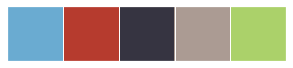

In [200]:
colors = ['#6aabd1', '#b63b2e', '#363441', '#ab9b93', '#abd16a']
pal = sns.color_palette(colors)

sns.palplot(pal)

## Grid plot with network parameters

In [201]:
hue_order = ["Healthy",
            "Lum A",
            "Lum B",
            "Her2",
            "Basal"]

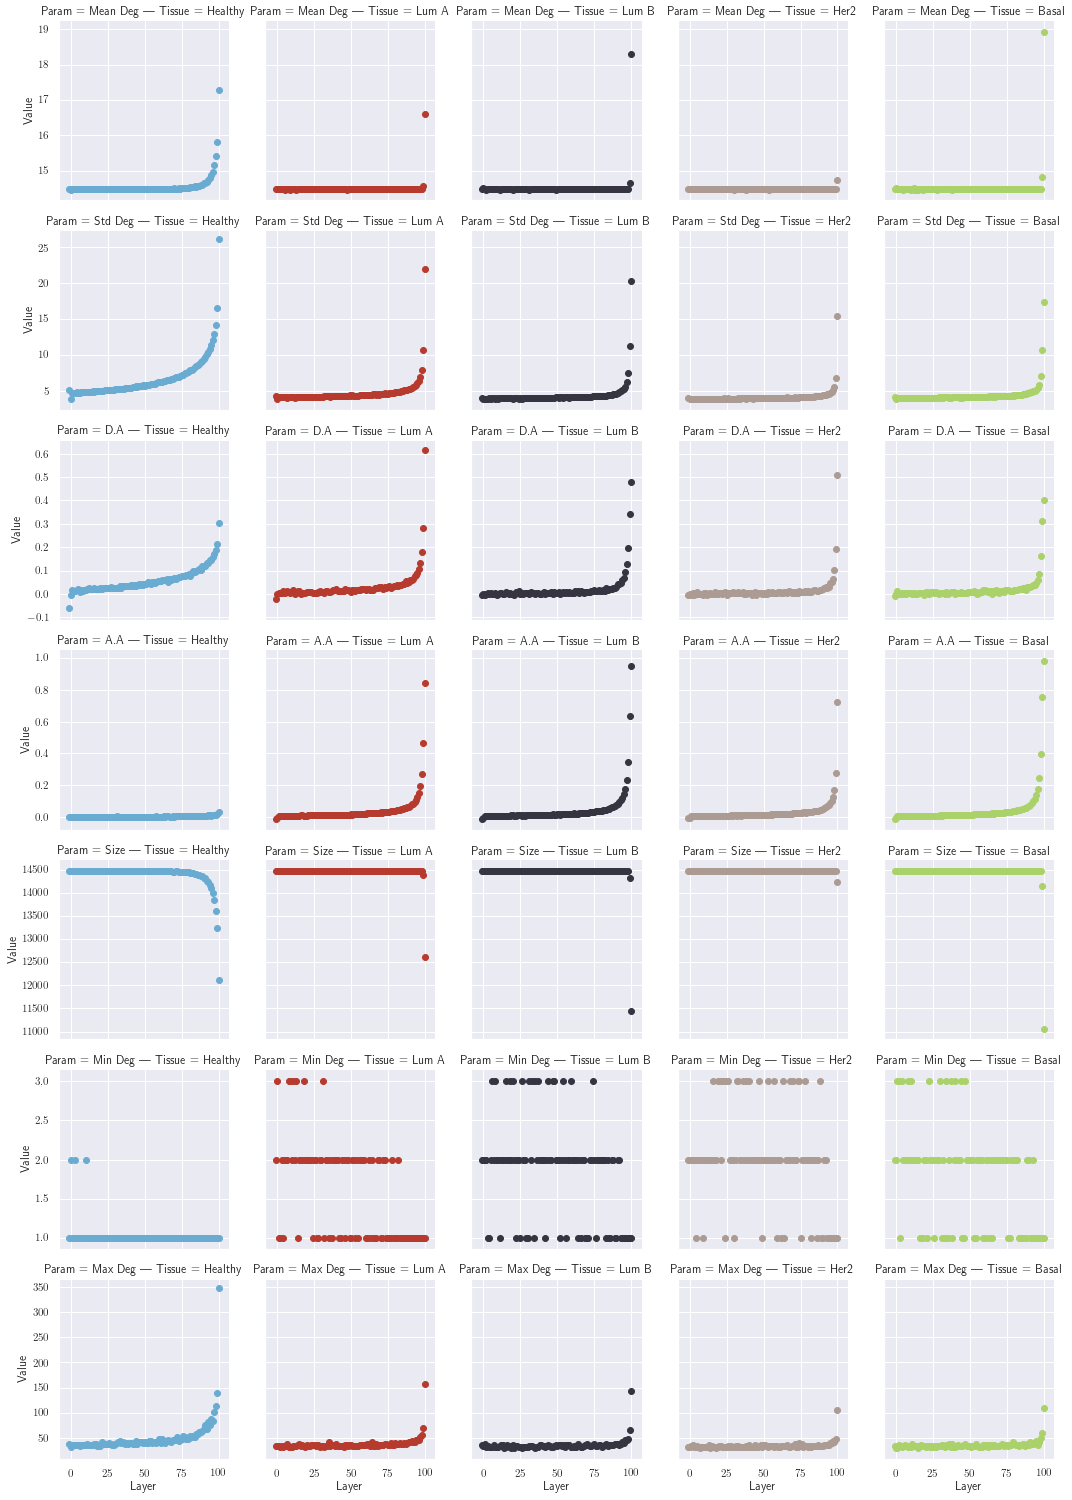

In [202]:
g = sns.FacetGrid(df_tidy, col="Tissue", row="Param", hue="Tissue",
                 hue_order=hue_order, sharex=True, sharey="row", palette=pal)
g.map(plt.scatter, "Layer", "Value")
# g.savefig(join(FIG, 'facet_grid_param.png'), dpi=300)

## Regression plot attribute assortativity and degree assortativity

In [187]:
sns.regplot?

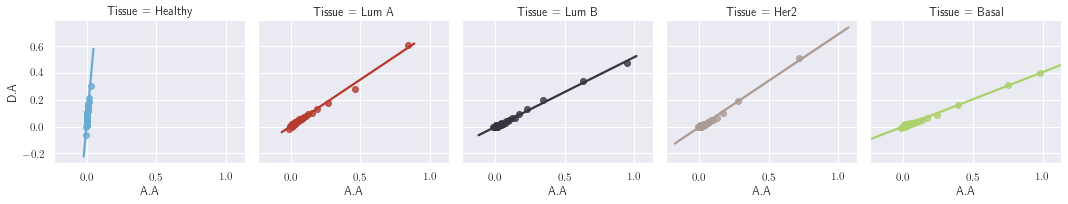

In [189]:
g = sns.FacetGrid(df, col="Tissue", hue="Tissue",
                 hue_order=hue_order, sharex=True, sharey="row", palette=pal)
g.map(sns.regplot, 'A.A', 'D.A', ci=None)
g.savefig(join(FIG, 'regplot_ass_ass_attr.png'), dpi=300)

### Slopes of the models

In [186]:
for tissue in ['Healthy', 'Lum A', 'Lum B', 'Her2', 'Basal']:
    X = df.loc[df.Tissue==tissue, 'A.A'].values
    Y = df.loc[df.Tissue==tissue, 'D.A'].values
    model = sm.OLS(Y, X).fit()

    print("Slope for {0}: {1:.2f}".format(tissue, model.params[0]))

Slope for Healthy: 13.14
Slope for Lum A: 0.71
Slope for Lum B: 0.51
Slope for Her2: 0.67
Slope for Basal: 0.41


In [182]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.800e+33
Date:                Thu, 03 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:21:42   Log-Likelihood:                 4092.2
No. Observations:                 102   AIC:                            -8182.
Df Residuals:                     101   BIC:                            -8180.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0000   1.62e-17   6.16e+16      0.000       1.000       1.000
==============================================================================
Omnibus:                       74.454   Durbin-Watson:                   1.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.208
Skew:                           2.566   Prob(JB):                     5.45e-77
Kurtosis:                      10.503   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""